# Sparse Gaussian Process Regression


Let's set some setting for this Jupyter Notebook.

In [2]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

 Now, let's import the `SparseGaussianProcessRegression` algorithm from the `pymc-learn` package.

In [3]:
import pmlearn
from pmlearn.gaussian_process import SparseGaussianProcessRegressor
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc0


## Step 1: Prepare the data
Generate synthetic data.

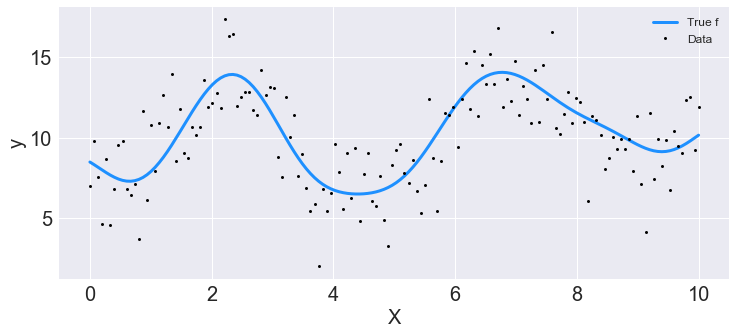

In [4]:
n = 150 # The number of data points
X = np.linspace(start = 0, stop = 10, num = n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
length_scale_true = 1.0
signal_variance_true = 3.0
cov_func = signal_variance_true**2 * pm.gp.cov.ExpQuad(1, length_scale_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Constant(10)

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of Gaussian distributed noise
# The standard deviation of the noise is `sigma`
noise_variance_true = 2.0
y = f_true + noise_variance_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Step 2: Instantiate a model

In [6]:
model = SparseGaussianProcessRegressor()

## Step 3: Perform Inference

In [7]:
model.fit(X_train, y_train)

Average Loss = -4,669.3: 100%|██████████| 200000/200000 [06:12<00:00, 536.41it/s]
Finished [100%]: Average Loss = -4,669.6


SparseGaussianProcessRegressor(prior_mean=0.0)

## Step 4: Diagnose convergence

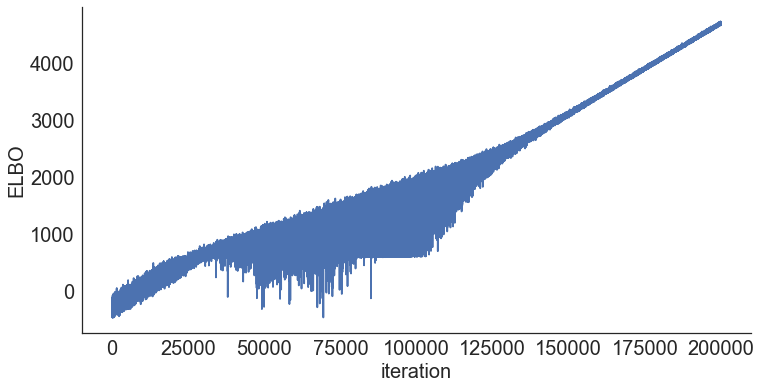

In [8]:
model.plot_elbo()

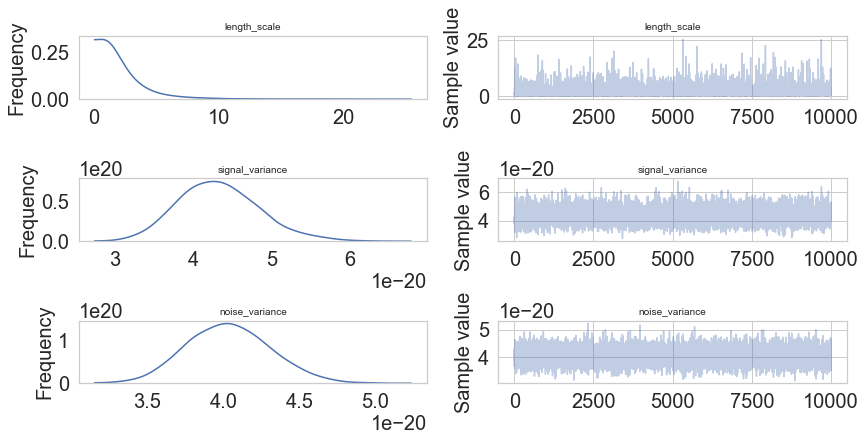

In [8]:
pm.traceplot(model.trace);

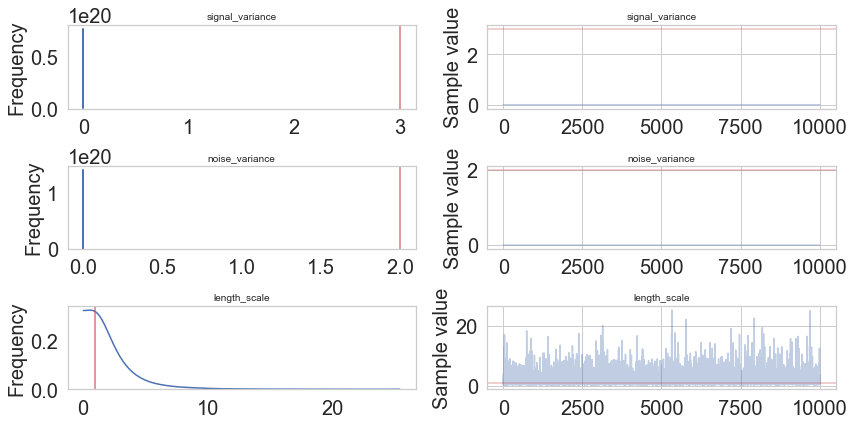

In [9]:
pm.traceplot(model.trace, lines = {"signal_variance": signal_variance_true, 
                                 "noise_variance": noise_variance_true, 
                                 "length_scale": length_scale_true}, 
             varnames=["signal_variance", "noise_variance", "length_scale"]);

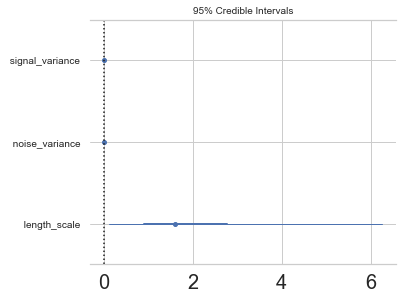

In [11]:
pm.forestplot(model.trace, varnames=["signal_variance", "noise_variance", "length_scale"]);

## Step 5: Critize the model

In [12]:
pm.summary(model.trace, varnames=["signal_variance", "length_scale", "noise_variance"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
signal_variance__0,2.266128e-20,3.632205e-21,3.731201e-23,1.578536e-20,2.999736e-20
length_scale__0_0,2.233311e+00,2.182089e+00,2.042519e-02,1.187429e-01,6.257235e+00
noise_variance__0,2.216509e-20,3.491209e-21,3.041214e-23,1.571128e-20,2.914439e-20


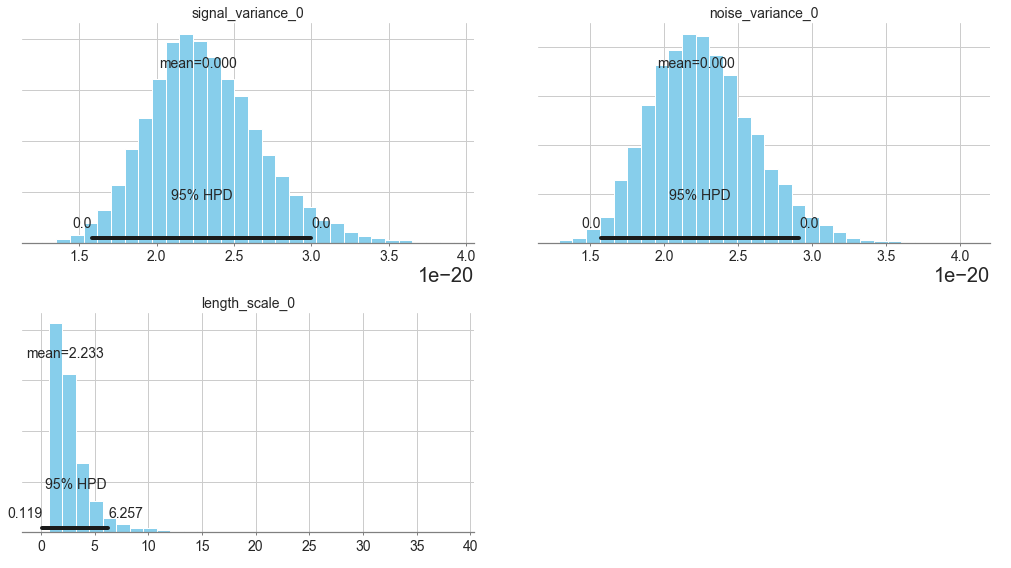

In [13]:
pm.plot_posterior(model.trace, varnames=["signal_variance", "noise_variance", "length_scale"], 
                 figsize = [14, 8]);

In [8]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["length_scale", "signal_variance", "noise_variance"],
              "Predicted Mean Value": [float(model.trace["length_scale"].mean(axis=0)), 
                               float(model.trace["signal_variance"].mean(axis=0)), 
                               float(model.trace["noise_variance"].mean(axis=0))],
              "True value": [length_scale_true, signal_variance_true, noise_variance_true]})

,Parameter,Predicted Mean Value,True value
0,length_scale,2.182521,1.0
1,signal_variance,9.261435,3.0
2,noise_variance,0.002241,2.0


## Step 6: Use the model for prediction

In [ ]:
y_predict1 = model.predict(X_test)

In [ ]:
y_predict1

In [ ]:
model.score(X_test, y_test)

In [ ]:
model.save('pickle_jar/sgpr')

#### Use already trained model for prediction

In [ ]:
model_new = SparseGaussianProcessRegressor()
model_new.load('pickle_jar/sgpr')
model_new.score(X_test, y_test)

## Multiple Features

In [ ]:
num_pred = 2
X = np.random.randn(1000, num_pred)
noise = 2 * np.random.randn(1000,)
Y = X.dot(np.array([4, 5])) + 3 + noise

In [ ]:
y = np.squeeze(Y)

In [ ]:
model_big = SparseGaussianProcessRegressor()

In [ ]:
model_big.fit(X, y, inference_args={"n" : 1000})

In [ ]:
pm.summary(model_big.trace, varnames=["signal_variance", "length_scale", "noise_variance"])

## MCMC

### Perform inference

In [8]:
model2 = SparseGaussianProcessRegressor()
model2.fit(X_train, y_train, inference_type='nuts')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, noise_variance_log__, signal_variance_log__, length_scale_log__]
100%|██████████| 1500/1500 [00:24<00:00, 60.20it/s]
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, noise_variance_log__, signal_variance_log__, length_scale_log__]
100%|██████████| 4000/4000 [11:41<00:00,  5.70it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or 

GaussianProcessRegression()

### Diagnose convergence

<IPython.core.display.Javascript object>


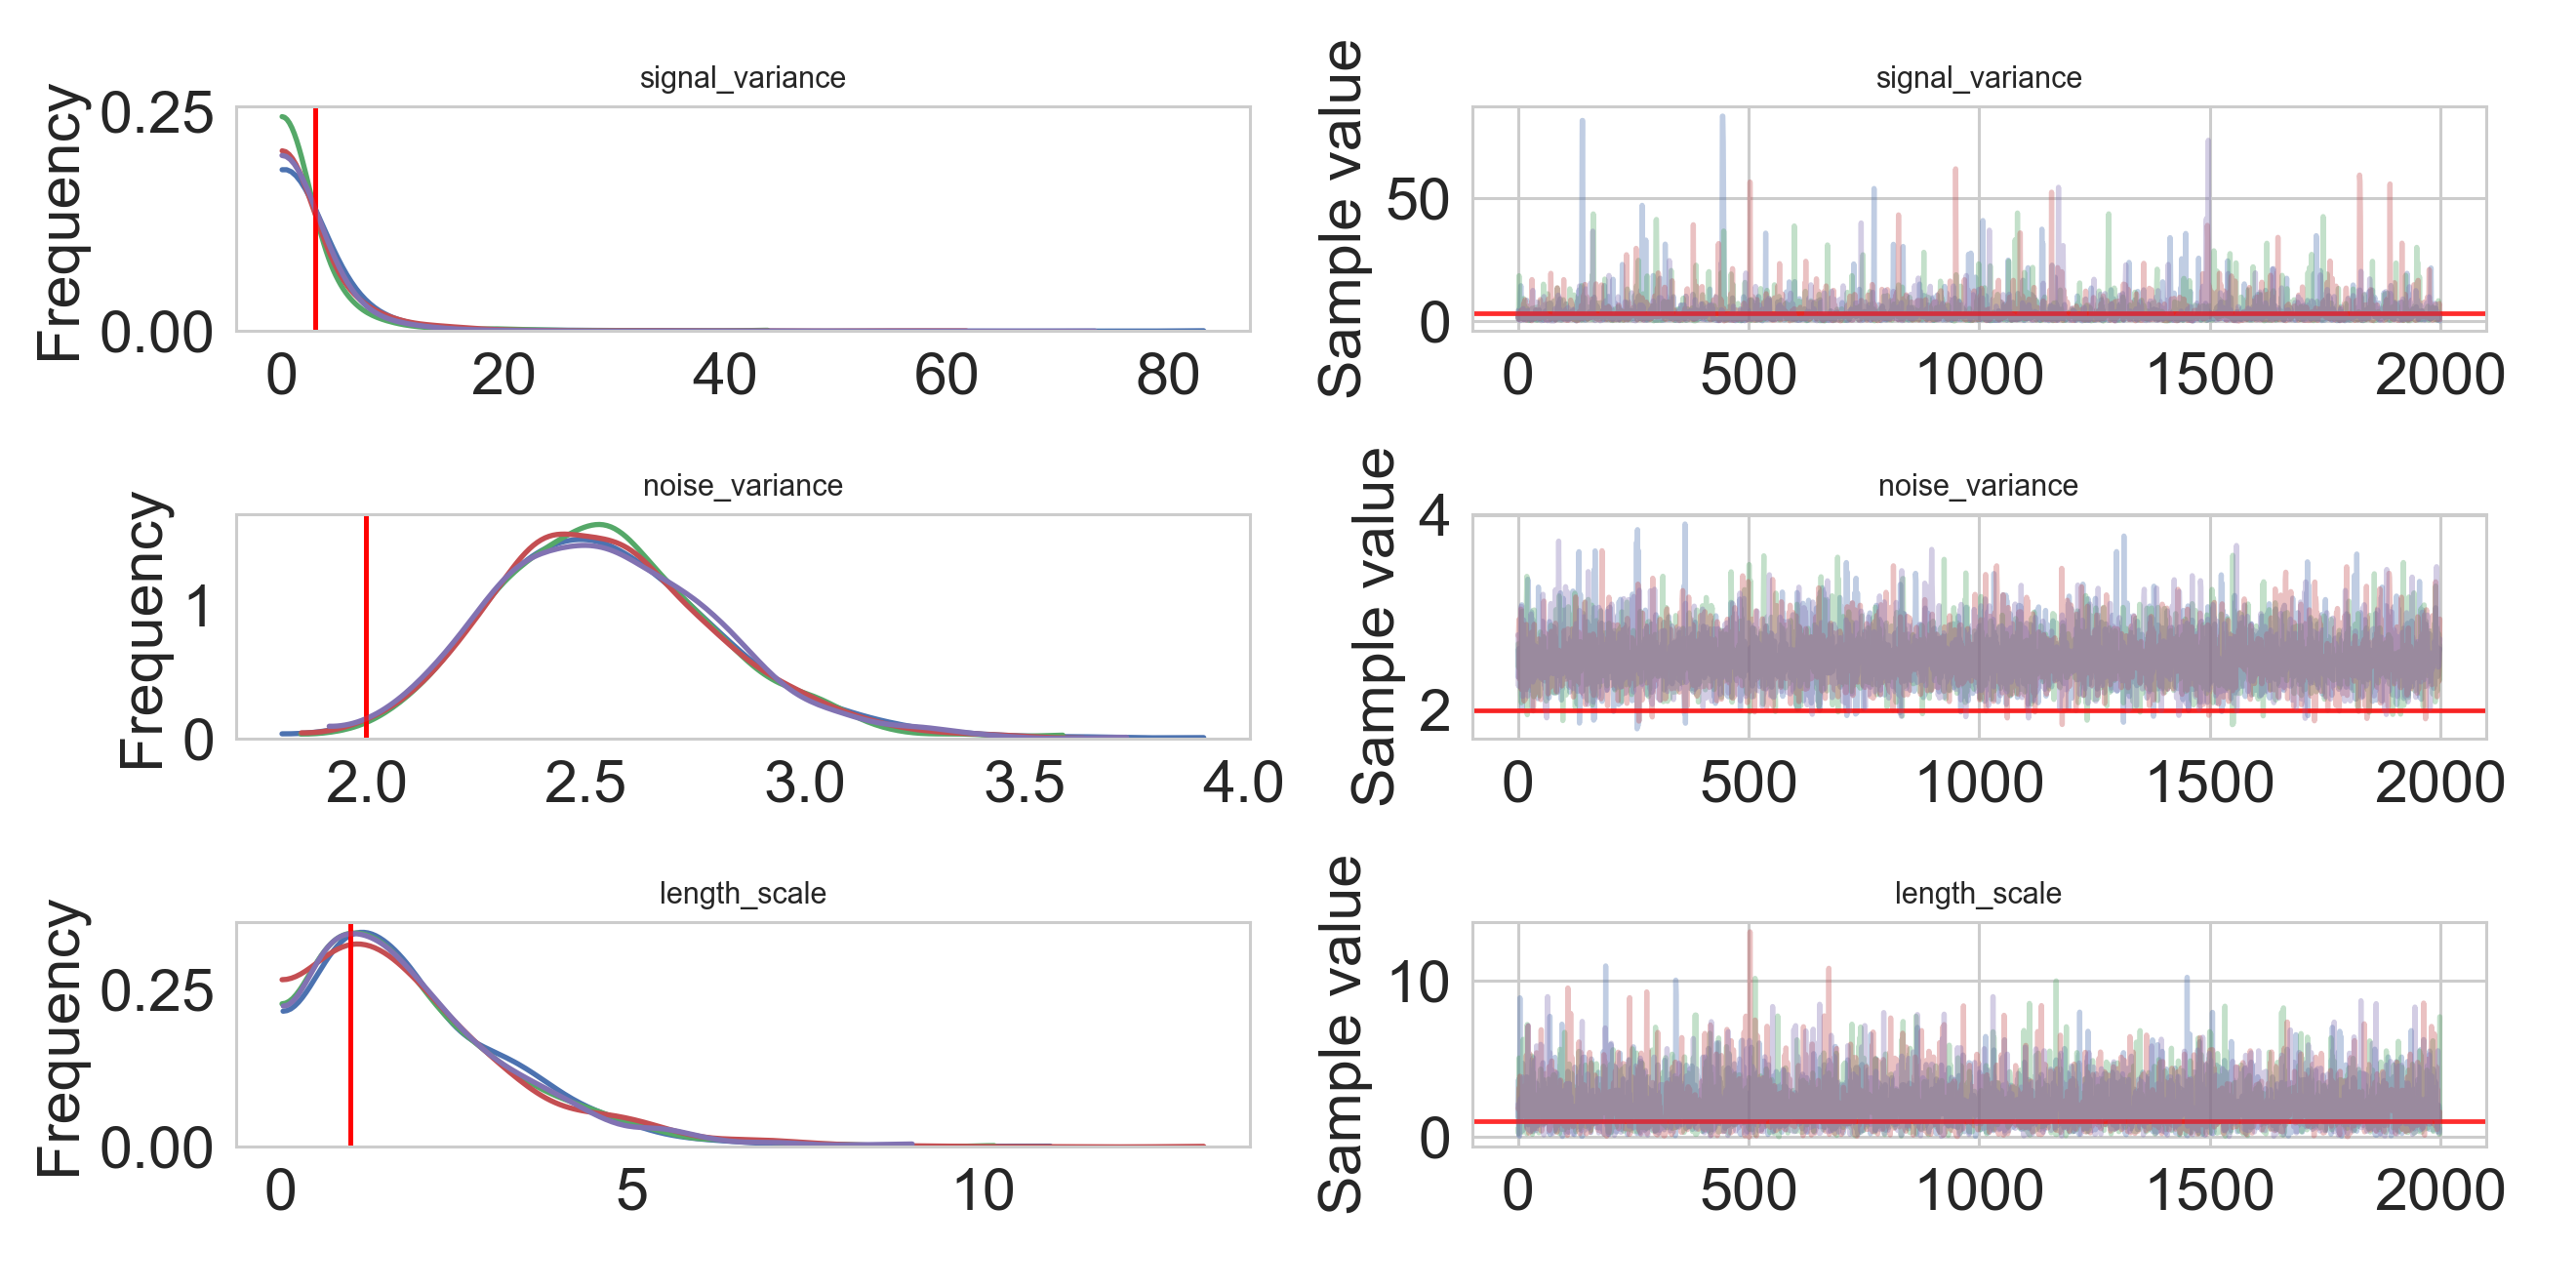

In [18]:
pm.traceplot(model2.trace, lines = {"signal_variance": signal_variance_true, 
                                 "noise_variance": noise_variance_true, 
                                 "length_scale": length_scale_true}, 
             varnames=["signal_variance", "noise_variance", "length_scale"]);

In [19]:
pm.gelman_rubin(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale"])

{'signal_variance': array([ 1.00134827]),
 'noise_variance': array([ 0.99982997]),
 'length_scale': array([[ 0.9997668]])}

<IPython.core.display.Javascript object>


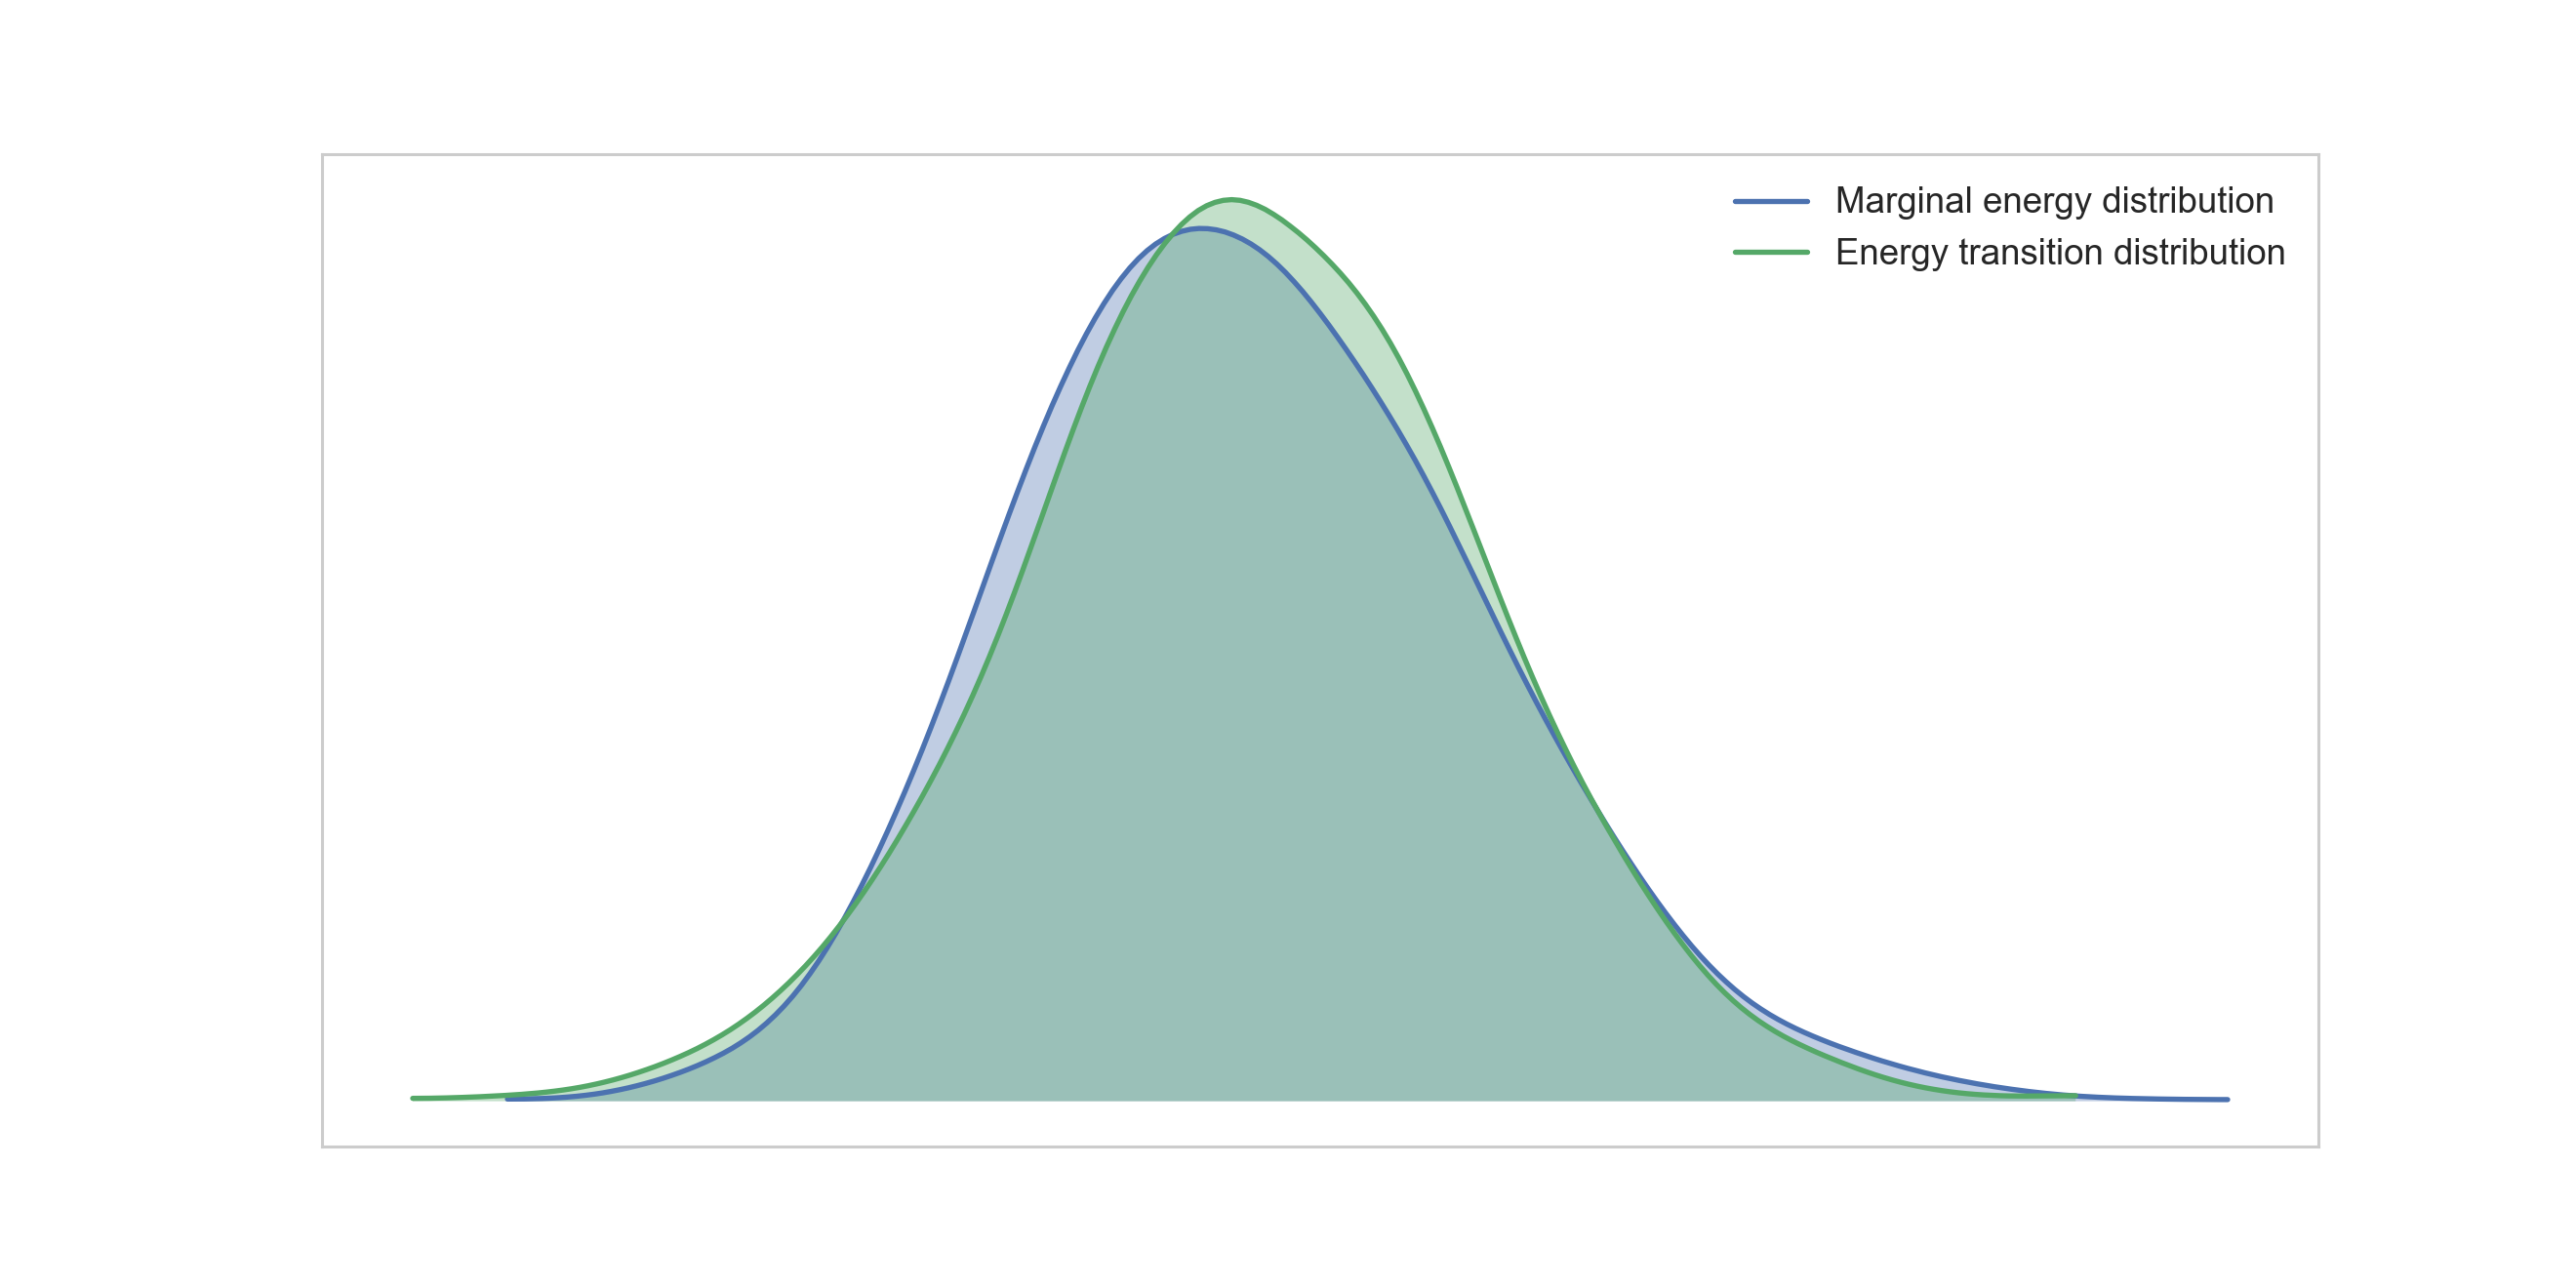

In [22]:
pm.energyplot(model2.trace);

In [21]:
pm.forestplot(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale"]);

### Criticize the model

In [10]:
pm.summary(model2.trace, varnames=["signal_variance", "length_scale", "noise_variance"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
signal_variance__0,3.354521,5.059969,0.072611,0.004388,10.494186,3949.565916,1.001348
length_scale__0_0,2.004001,1.446405,0.013286,0.033810,4.790922,12131.009636,0.999767
noise_variance__0,2.544328,0.264045,0.003021,2.074630,3.086981,8803.802924,0.999830


In [11]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["length_scale", "signal_variance", "noise_variance"],
              "Predicted Mean Value": [float(model2.trace["length_scale"].mean(axis=0)), 
                               float(model2.trace["signal_variance"].mean(axis=0)), 
                               float(model2.trace["noise_variance"].mean(axis=0))],
              "True value": [length_scale_true, signal_variance_true, noise_variance_true]})

,Parameter,Predicted Mean Value,True value
0,length_scale,2.004001,1.0
1,signal_variance,3.354521,3.0
2,noise_variance,2.544328,2.0


<IPython.core.display.Javascript object>


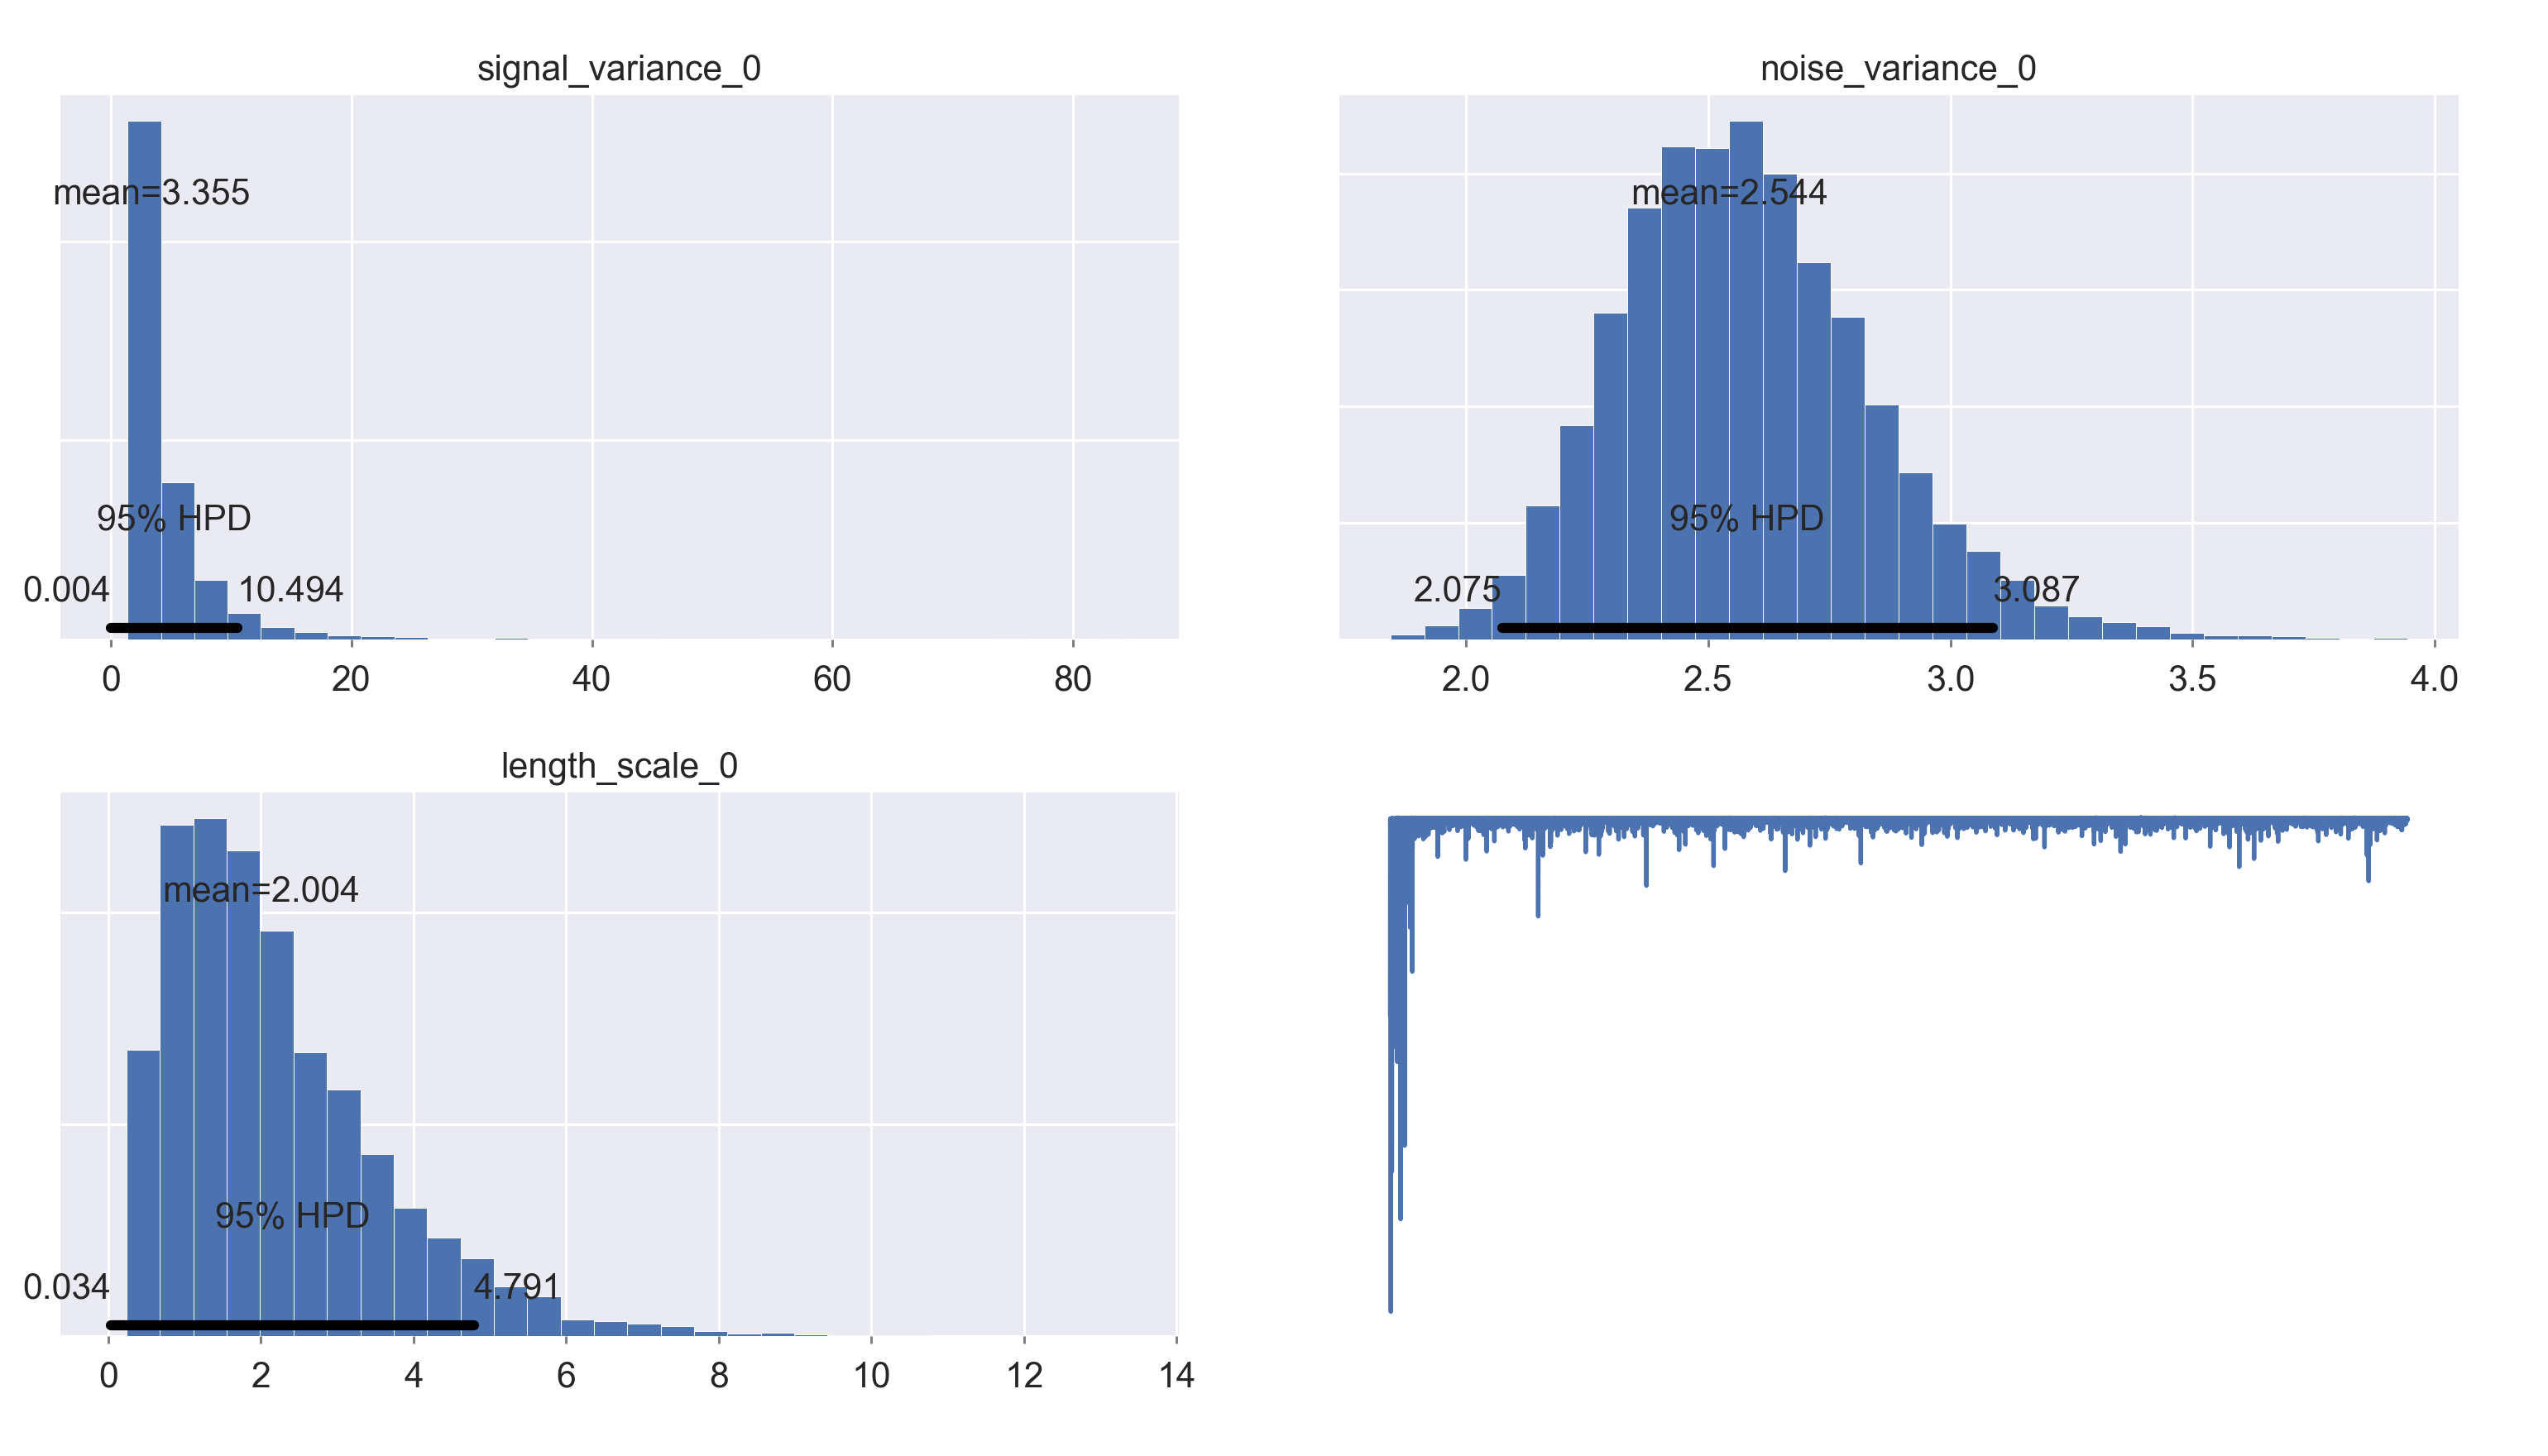

In [12]:
pm.plot_posterior(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale"], 
                 figsize = [14, 8]);

### Use the model for prediction

In [28]:
y_predict2 = model2.predict(X_test)

100%|██████████| 2000/2000 [00:01<00:00, 1332.79it/s]


In [29]:
y_predict2

array([ 0.71831924,  0.70266214,  0.74034292,  0.73223746,  0.76798942,
        0.78039904,  0.80198739,  0.77559783,  0.74532885,  0.75839183,
        0.69163726,  0.6490964 ,  0.71534946,  0.65845406,  0.66052402,
        0.80801464,  0.69148553,  0.61070685,  0.69928683,  0.75866764,
        0.6620472 ,  0.73977574,  0.70854909,  0.70340364,  0.70960481,
        0.69097856,  0.69340258,  0.72408786,  0.81266196,  0.79486012,
        0.72997809,  0.66805751,  0.72690218,  0.71025724,  0.72545681,
        0.69062513,  0.75047548,  0.64446808,  0.78133024,  0.69365793,
        0.78675961,  0.7909775 ,  0.66224847,  0.67357815,  0.82613138,
        0.76196312,  0.76742   ,  0.67757641,  0.67067013,  0.70072039])

In [30]:
model2.score(X_test, y_test)

100%|██████████| 2000/2000 [00:01<00:00, 1464.52it/s]


-0.011313490552906202

In [ ]:
model2.save('pickle_jar/')
model2_new = SparseGaussianProcessRegressor()
model2_new.load('pickle_jar/')
model2_new.score(X_test, y_test)